# Deep Learning Assignment 2 - 
Patrick Garrett (01571095) 

In [ ]:
import os
import cv2
import keras
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import itertools
from keras.preprocessing import image
import matplotlib.image as mpimg

## Part 1 - Choosing a dataset <br>
For this assignment, I chose to perform classification on images of cows and horses.<br>
I utilised a dataset of creature images available on kaggle under the name of Animals-10:
https://www.kaggle.com/alessiocorrado99/animals10<br><br>
This dataset contains images extracted from google images, separated into a variety of different animal categories. <br><br>
To create a my datasets, I chose the horse and cow category folders and separated each into training, validation and test sets. The training set contains approx 2000 images, validation 500 images, and testing circa 600 images. The images in each set are evenly divided between horses and cows. I chose images for each set by simply selecting final n images in each animal category folder (e.g. selecting the final 300 images in the horse image folder as the horse test images). There was no order or pattern to type or composition of images in each image folder so the distribution of images in each category was even.<br><br>
All images have dimensions of approx 300 x 225 pixels

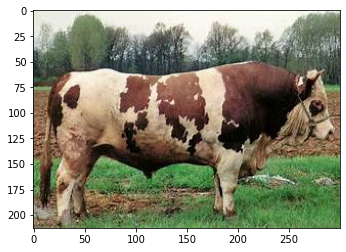

In [ ]:
#paths of typical images from test sets
cow_img = '/content/gdrive/MyDrive/animal_pictures_01/train/cows/OIP-23fps5xF_1X8Fs4YgPhEiwHaFQ.jpeg'
horse_img = '/content/gdrive/MyDrive/animal_pictures_01/train/horses/OIP-8BsEP_ejMEJXqrVmKBm9kwAAAA.jpeg'


cow = mpimg.imread(cow_img)
imgplot = plt.imshow(cow)

plt.show()



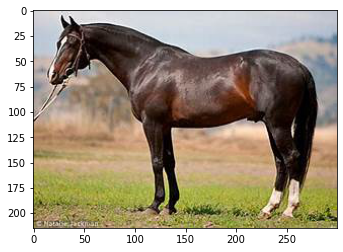

In [ ]:
horse = mpimg.imread(horse_img)
imgplot = plt.imshow(horse)

plt.show()

###  Part 2: Creating model, training it, and testing it on unseen data<br>
In part two we create a base image classification model in Keras, add extra layers to the model, add image augementation, train the model on pre-processed training images and then finally test the model on unseen test images.<br><br>

Note: Some of the code for part two was based on code we used for a previous image classification project this semester in another module. There may be some similarity between my code and that of my partner on that project Clitton Tauro.  

In [ ]:
#defining labels for two image categories
labels = ['cows', 'horses']
#224 is optimal img size for mobilenet
img_size = 224

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#method for extracting images for each image directory
#sets are divided based on their label (i.e. cows or horses)
def create_dataset(directory):
    data = []
    for label in labels: 
        path = os.path.join(directory, label) # path comprises the directory (e.g. test set directory) combined with the animal label
        class_number = labels.index(label) # classes are assigned a number, 0 for cow images, 1 for horse images
        for img in os.listdir(path):
          image_array = cv2.imread(os.path.join(path, img))[...,::-1] 
          resized_array = cv2.resize(image_array, (img_size, img_size)) 
          data.append([resized_array, class_number])
    return np.array(data)

In [ ]:
#paths in google drive for each set of images
train_path = '/content/gdrive/MyDrive/animal_pictures_01/train'
test_path = '/content/gdrive/MyDrive/animal_pictures_01/test'
validate_path = '/content/gdrive/MyDrive/animal_pictures_01/validate'

In [ ]:
#creating training set
train = create_dataset(train_path)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


In [ ]:
#creating validation set
val = create_dataset(validate_path)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


In [ ]:
##creating test set
test = create_dataset(test_path)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


In [ ]:
#Pre-processing data. 
#Dividing data into different arrays based on the type(e.g. test, train) and class

l = []
for i in train:
    if(i[1] == 0):
        l.append("cows")
    else:
        l.append("horses")

x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

for feature, label in test:
  x_test.append(feature)
  y_test.append(label)

#divide by 255 to normalise between 0 and 1
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

# Reshape data and convert to numpy array
x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [ ]:
# perform image augmentation to expand dataset 
augment = ImageDataGenerator(
        rotation_range = 30,  # rotate images
        width_shift_range=0.1,  # shift images
        height_shift_range=0.1,  
        horizontal_flip = True,  # flip images horizontally
        zoom_range = 0.5, # zoom in 
        vertical_flip=True)  # flip images vertically

augment.fit(x_train)

#Convert the class labels to one-hot encoding format
y_train = to_categorical(y_train, num_classes=2)
y_val_x = to_categorical(y_val, num_classes=2)

Base Model: I chose the MobilenetV2 architecture as a base model. The main reasons for this choice was because of Mobilenet's efficiency and how effective it proved to be in image classification in a previous project I used it in.

In [ ]:
#Create the base MobileNetv2 model using pre-trained weights on Imagenet dataset
#classification head is not used
base_model = keras.applications.MobileNetV2(input_shape = (224, 224, 3), include_top = False, weights = "imagenet")

In [ ]:
#freezing the base model layers
base_model.trainable = False

Adding layers to the base model:<br>
GlobalMaxPooling: Pools location of features on the feature map. This makes the model less sensitive to alterations of location of features in the image.1 <br>
Dropout: Layer outputs are randomly ignored ("dropped out"). It improves the generalisation ability of the model and reduces overfitting. 2<br>
Dense layer: outputs 2 neurons, representing the binary classification of inputs images.

1 - https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/<br>
2- https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/

In [ ]:
#Add additional layers to the existing model and create a new model
model = keras.Sequential([base_model,
                                 keras.layers.GlobalMaxPooling2D(),
                                 keras.layers.Dropout(0.5),
                                 keras.layers.Dense(2, activation="sigmoid")
                                ])

In [ ]:
#using adam optimiser with learning rate of 0.001
model.compile(optimizer=keras.optimizers.Adam(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

Output shape of mobilenetv2 base layer is (None, 7, 7, 1280) <br>
This means it performs average pooling of each 7 x 7 patch of the feature map with an output of 1280 neurons.



In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


Model Training: We performing training of model on our training set. Training is performed over 25 epochs (I learned through trial and error that much more than 25 epochs does not significantly improve accuracy on validation set)

In [ ]:
model.fit(x_train,y_train,epochs = 25, validation_data = (x_val, y_val_x))

Epoch 1/25
64/64 [==============================] - 11s 124ms/step - loss: 1.9604 - accuracy: 0.6314 - val_loss: 0.2145 - val_accuracy: 0.9280
Epoch 2/25
64/64 [==============================] - 7s 105ms/step - loss: 0.6728 - accuracy: 0.8690 - val_loss: 0.1677 - val_accuracy: 0.9560
Epoch 3/25
64/64 [==============================] - 7s 106ms/step - loss: 0.5687 - accuracy: 0.8937 - val_loss: 0.1578 - val_accuracy: 0.9340
Epoch 4/25
64/64 [==============================] - 7s 106ms/step - loss: 0.4293 - accuracy: 0.9114 - val_loss: 0.1006 - val_accuracy: 0.9720
Epoch 5/25
64/64 [==============================] - 7s 105ms/step - loss: 0.3901 - accuracy: 0.9173 - val_loss: 0.0979 - val_accuracy: 0.9680
Epoch 6/25
64/64 [==============================] - 7s 106ms/step - loss: 0.3298 - accuracy: 0.9222 - val_loss: 0.0839 - val_accuracy: 0.9720
Epoch 7/25
64/64 [==============================] - 7s 106ms/step - loss: 0.3040 - accuracy: 0.9263 - val_loss: 0.0902 - val_accuracy: 0.9660
Epoch

In [ ]:
#performing prediction of the unseen x_test images
predictions = model.predict_classes(x_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Classification on unseen data: Model has approx 96% accuracy in predicting unseen image classes

In [ ]:
print(classification_report(y_test, predictions, target_names = ['cows','horses']))

              precision    recall  f1-score   support

        cows       0.94      0.98      0.96       300
      horses       0.98      0.94      0.96       297

    accuracy                           0.96       597
   macro avg       0.96      0.96      0.96       597
weighted avg       0.96      0.96      0.96       597



### **Part 3: Choosing neurons that correlate with either class label**<nr><nr>


In part 3, we create a new model comprised of the base model, a global average pooling layer, and a softmax layer.<br><br> We then perform prediction on the test set with this model. Output of these predictions will generate a scalar value for each of the 1280 neurons on the softmax layer<br><br>
We then analyse the values of the of neurons for each image and detect which neurons tend to correlate with either class value.



In [ ]:
#adding GlobalAveragePooling and Softmax layers to the base model 
model_2 = keras.Sequential([base_model,
                                 keras.layers.GlobalAveragePooling2D(),
                                 keras.layers.Softmax()
                                ])

In [ ]:
#predicting values of test set with the second model
predict_2 = model_2.predict(x_test) # scalar outputs for softmax output

This will create a output of shape (597, 1280) - 597 test images, with 1280 neurons per image

In [ ]:
predict_2.shape

(597, 1280)

For finding the neurons that correlate most with each class, I :<br>
- first identified the top N values for each image in the test set.<br>
- I then separated these along class lines.<br>
- collated the lists of top neurons into one list<br>
- I then counted the frequency of each neuron within this list<br>
- Finally, I returned the three neurons with greatest frequency per class

In [ ]:
#method for creating a dictionary containing the frequency of each value in an inputted list. 
#it then returns the top three keys in that dictionary
#this method is used for identifying top 3 most frequent neurons in a list of neurons
def Return_Top_Neurons(my_list):
  
    # Creating an empty dictionary 
    freq = {}
    for item in my_list:
        if (item in freq):
            freq[item] += 1
        else:
            freq[item] = 1
    
    return sorted(freq, key=freq.get, reverse=True)[:3]
  
  

In [ ]:
#using predictions of model 2, find top n-valued neurons for each image

def get_top_neurons(predictions,n):
  top_ns = list()
  for p in predictions:
    top_ns.append(np.argsort(p)[-n:])

  #separate list into cow and horse images
  cows = top_ns[:300]
  horses = top_ns[300:]

  #concatenate all top neurons for each image into one list
  top_cows = list(itertools.chain.from_iterable(cows))
  top_horses = list(itertools.chain.from_iterable(horses))

  #identify top 3 neurons (for each class) that consistently are highly represented in each image
  top_3_cow_neurons = Return_Top_Neurons(top_cows)
  top_3_horses_neurons = Return_Top_Neurons(top_horses)

  return top_3_cow_neurons,top_3_horses_neurons

In [ ]:
#finding top neurons for each class based on list of neurons that were most frequently in the top 50 highest-valued neurons per image
top_cow_neurons,top_horse_neurons = get_top_neurons(predict_2,50)

Top 3 neurons correlating with cow images were 133, 141 and 699<br>
Top 3 neurons correlating with horse images were 327, 571 and 1273<br>
These neurons were, for both classes, consistently the top 3 valued neurons returned by the above methods.

# **Part 4: Creating 2-d outputs of neurons identified in part 3 to attempt object localisation**<br>
In part four I will test out if the neurons identified for each class in part 3 are accurate in locating the class item in an input image.


In [ ]:
#method for creating image tensor
def create_image_tensor(img_path):
  img = image.load_img(img_path, target_size=(224, 224))
  img_tensor = image.img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis=0)
  img_tensor /= 255.
  return img_tensor

In [ ]:
#paths to randomly chosen cow images in the test set
cow_img_1_path = '/content/gdrive/MyDrive/animal_pictures_01/test/cows/OIP-WuAbibr1sF9LzkKqS6PPzgHaFl.jpeg'
cow_img_2_path = '/content/gdrive/MyDrive/animal_pictures_01/test/cows/OIP-vq0SlJWU3hJzKZ7wYOr1LAHaE7.jpeg'
cow_img_3_path = '/content/gdrive/MyDrive/animal_pictures_01/test/cows/OIP-w-kat7fDaBShb1DgVpvqPwHaFF.jpeg'

#paths to randomly chosen horses images in the test set
horse_img_1_path = '/content/gdrive/MyDrive/animal_pictures_01/test/horses/OIP-vVVAqIlaC8UlNB4i2LanlgHaGb.jpeg'
horse_img_2_path = '/content/gdrive/MyDrive/animal_pictures_01/test/horses/OIP-vDdFLJO4mP-SXvMl6s0jRgAAAA.jpeg'
horse_img_3_path = '/content/gdrive/MyDrive/animal_pictures_01/test/horses/OIP-u9slGe3LPiWnCPaDa94igQHaFp.jpeg'

#list of cow image tensors based on paths defined above
cow_img_tensors = list()
cow_img_tensors.append(create_image_tensor(cow_img_1_path))
cow_img_tensors.append(create_image_tensor(cow_img_2_path))
cow_img_tensors.append(create_image_tensor(cow_img_3_path))

#list of horse image tensors based on paths defined above
horse_img_tensors = list()
horse_img_tensors.append(create_image_tensor(horse_img_1_path))
horse_img_tensors.append(create_image_tensor(horse_img_2_path))
horse_img_tensors.append(create_image_tensor(horse_img_3_path))


In [ ]:
#display original image and the 2d outputs for each selected neuron
def visualise_outputs(base_model,img_tensor,neurons):
  #using the base model to predict values of input image
  pred = base_model.predict(img_tensor)

  #plotting the original image image alongside the 2-d outputs of each neuron identified in part 3
  fig, ax = plt.subplots(1,4, figsize=(15,15))
  ax[0].imshow(img_tensor[0])
  ax[0].axis('off')
  ax[0].set_title('Original Image')
  ax[1].matshow(pred[0, :, :,neurons[0]], cmap='viridis')
  ax[1].axis('off')
  ax[1].set_title("Neuron {}".format(neurons[0]))
  ax[2].matshow(pred[0, :, :,neurons[1]], cmap='viridis')
  ax[2].axis('off')
  ax[2].set_title("Neuron {}".format(neurons[1]))
  ax[3].matshow(pred[0, :, :,neurons[2]], cmap='viridis')
  ax[3].axis('off')
  ax[3].set_title("Neuron {}".format(neurons[2]))
 



## **Results**<br>
Horse Images<br>
All 3 neurons approximately located the horse in image 3. In image 2, the horse is not as accurately located. Neuron 1273 appears to be most effective neuron at locating horse objects  

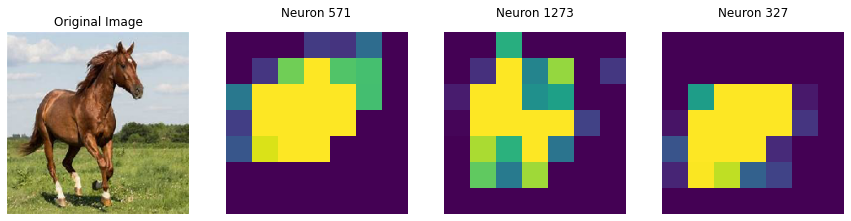

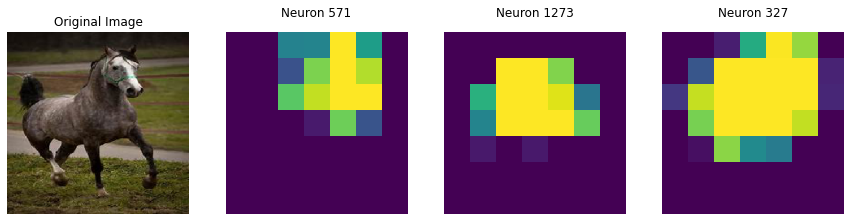

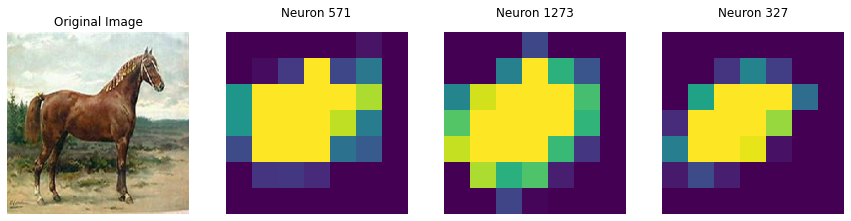

In [ ]:
for h in horse_img_tensors:
  visualise_outputs(base_model,h,top_horse_neurons)

Cow Images<br>
The top three cow neurons are perhaps not as accurate at locating objects as the corresponding horse neurons. Neuron 141 identified the approximate location of the cow in each image, however, neuron 699 was not as clear.

It would appear the model we have trained is not as successful at identifying cow objects as it can identify horse objects.

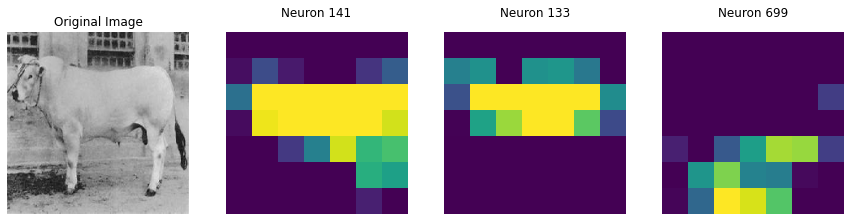

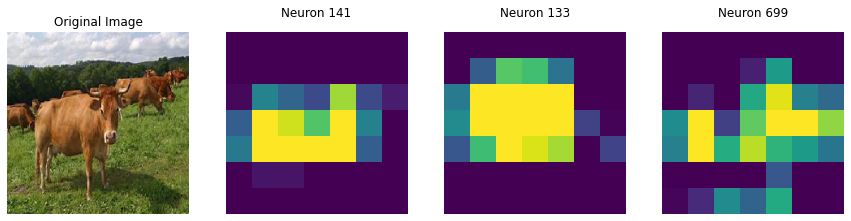

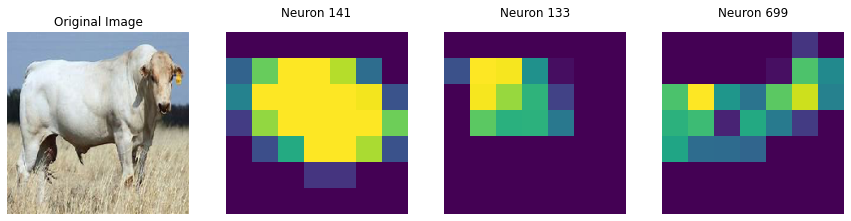

In [ ]:
for c in cow_img_tensors:
  visualise_outputs(base_model,c,top_cow_neurons)